In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import os
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
from collections import Counter
import seaborn as sns

In [2]:
#Imported Uruguay shape
uru = gpd.read_file("ury_adm_2020_shp.zip")

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'ury_adm_2020_shp.zip': 'ury_admbnda_adm0_2020' (default), 'ury_admbnda_adm1_2020', 'ury_admbnda_adm2_2020', 'ury_admbndl_ALL_2020'. Specify layer parameter to avoid this warning.
  result = read_func(


# Ploting functions

In [3]:
def means_plot(folder, month, year, variable=None, model_name=None, scenario=None):
    """
    Creates and displays plots for aggregated climate data (mean or sum) based on the provided parameters.

    Parameters:
    -----------
    folder : str
        Path to the directory containing the dataset files.
    month : int
        The month (0-11) for which the plot should be generated.
    year : int, optional
        The year for which the plot should be generated. 
    variable : str
        The variable to plot (e.g., 'pr','sfcWind','tas')
    model_name : str
        The name of the model to filter data by.
    scenario : str
        The scenario to filter data by. 

    Notes:
    ------
    - If the variable is 'pr' (precipitation), the sum of daily values is aggregated for the month.
    - For other variables like wind speed and temperature, the mean of daily values is aggregated for the month.
    - The 'pr' rasters are treated differently as they contain two variables for precipitation with different units.

    Output:
    -------
    Displays the plot for the specified month and variable. The plot will show aggregated values (sum or mean) for the selected month.
    """

    
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (year is None or year in file) and (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            data = os.path.join(file_path)
            ds_masked = xr.open_dataset(data)
        
            # Create a new coordinate 'year_month' by extracting the year and month
            ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

            if variable=='pr':
                #For precipitation aggregation, the sum of daily values is calculated for one month.
                ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)
            else:
                #For wind speed and temperature aggregation, the mean of daily values is calculated for one month.
                ds_monthly = ds_masked.groupby('year_month').mean(skipna=False)

            #Create plots; the 'pr' plot is differentiated because the 'pr' rasters have two variables with different units.
            if variable=='pr':
                fig, ax = plt.subplots()
                ds_monthly['pr_mmd'].isel(year_month=month).plot(ax=ax)
                uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
                plt.show()
            else:
                fig, ax = plt.subplots()
                ds_monthly[f'{variable}'].isel(year_month=month).plot(ax=ax)
                uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
                plt.show()
            
            plt.show()

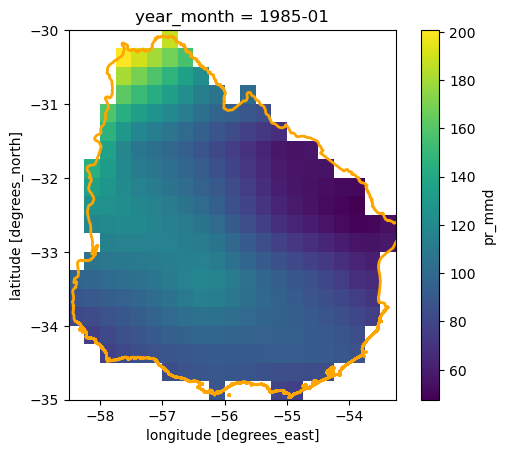

In [4]:
means_plot('filtered_data',month=0,year='1985',variable='pr',model_name='TaiESM1',scenario='historical')

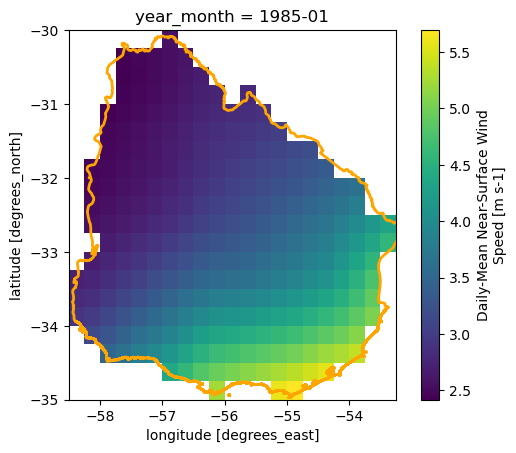

In [5]:
means_plot('filtered_data',month=0,year='1985',variable='sfcWind',model_name='EC-Earth3',scenario='historical')

In [6]:
def monthly_plot(folder, year, variable=None, model_name=None, scenario=None):
    """
    Generates and displays monthly aggregated spatial plots for climate data.

    Parameters:
    -----------
    folder : str
        Path to the directory containing the dataset files.
    year : int, optional
        The year for which the plot should be generated. 
    variable : str
        The variable to plot (e.g., 'pr','sfcWind','tas')
    model_name : str
        The name of the model to filter data by.
    scenario : str
        The scenario to filter data by. 

    Notes:
    ------
    - If the variable is 'pr' (precipitation), the sum of daily values is aggregated for each month.
    - For other variables like wind speed and temperature, the mean of daily values is aggregated for each month.
    - The 'pr' rasters are treated differently as they contain two variables with different units.

    Output:
    -------
    Displays monthly spatial plots with aggregated values (sum or mean) for the specified year and variable.
    """

    
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (year is None or year in file) and (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            data = os.path.join(file_path)
            ds_masked = xr.open_dataset(data)
        
            # Create a new coordinate 'year_month' by extracting the year and month
            ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

            if variable=='pr':
                #For precipitation aggregation, the sum of daily values is calculated for one month.
                ds_monthly = ds_masked.groupby('year_month').sum(dim='time',skipna=False)
            else:
                #For wind speed and temperature aggregation, the mean of daily values is calculated for one month.
                ds_monthly = ds_masked.groupby('year_month').mean(dim='time',skipna=False)

            #Create plots; the 'pr' plot is differentiated because the 'pr' rasters have two variables with different units.
            if variable=='pr':
                 # ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'],skipna=True)
                ds_monthly['pr_mmd'].plot.imshow(x="lon", y="lat", col="year_month", col_wrap=4,aspect=1, size=3)
            else:
                # ds_monthly_spatial_mean = ds_monthly[f'{variable}'].mean(dim=['lat', 'lon'],skipna=True)
                ds_monthly[f'{variable}'].plot.imshow(x="lon", y="lat", col="year_month", col_wrap=4,aspect=1, size=3)
            
            plt.show()

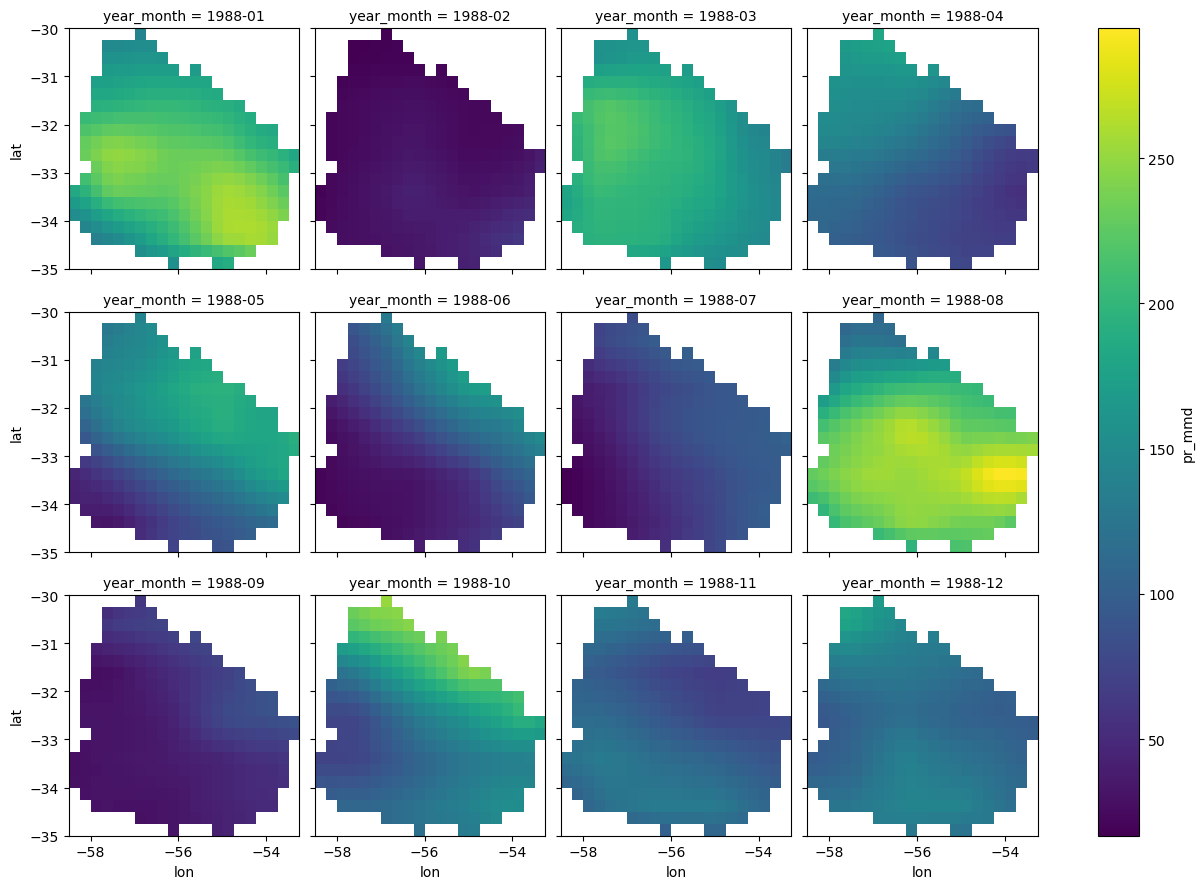

In [7]:
monthly_plot('filtered_data',year='1988',variable='pr',model_name='TaiESM1',scenario='historical')

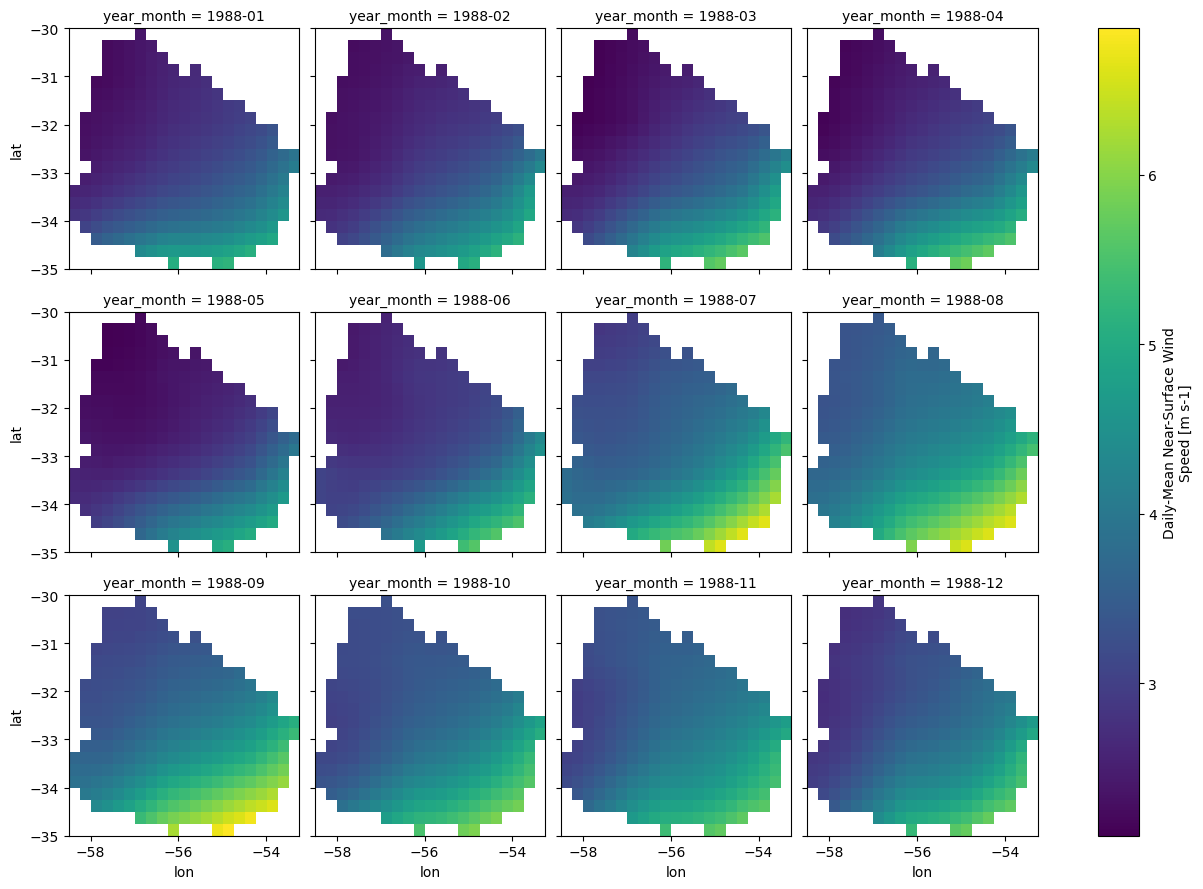

In [8]:
monthly_plot('filtered_data',year='1988',variable='sfcWind',model_name='EC-Earth3',scenario='historical')

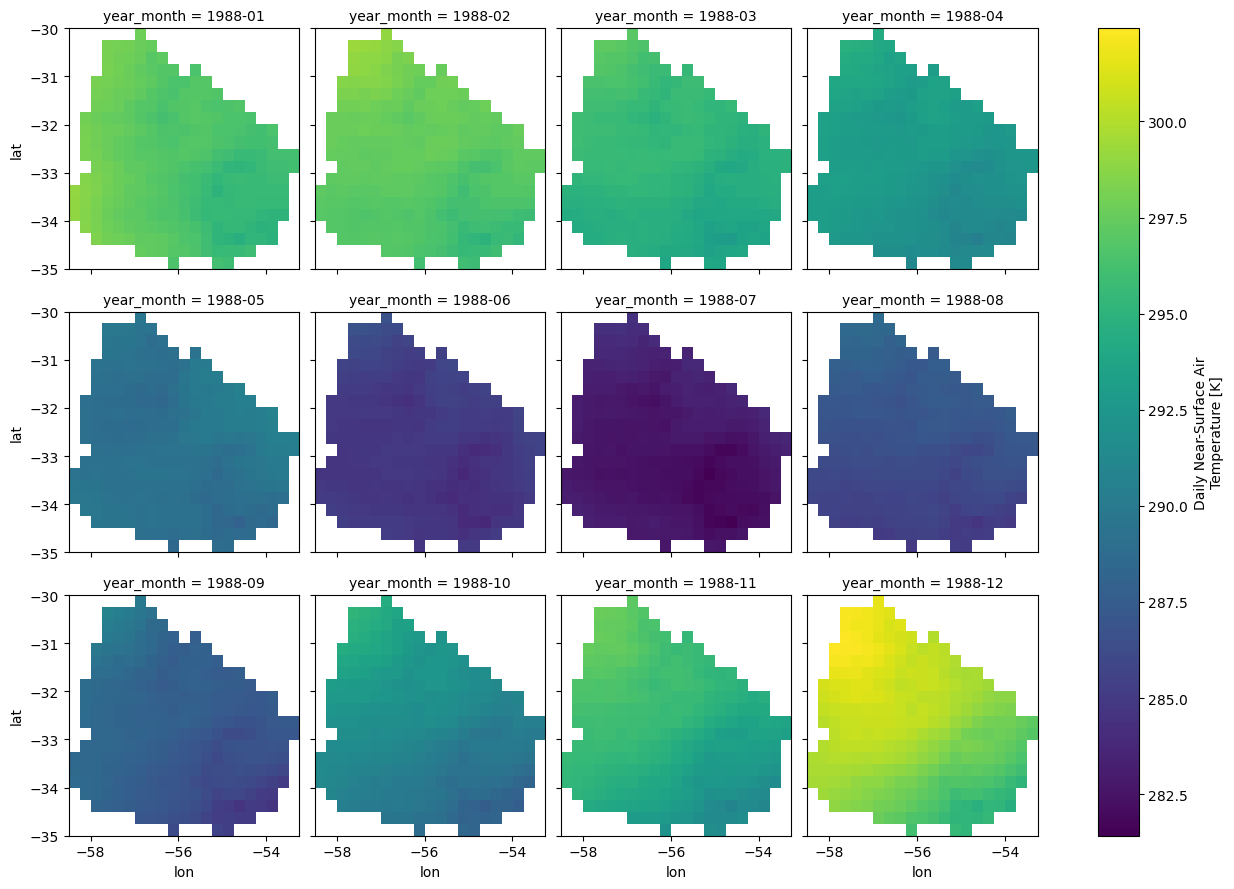

In [9]:
monthly_plot('filtered_data',year='1988',variable='tas',model_name='EC-Earth3',scenario='historical')

# Analysis functions

## Workflow
In this section, I present the functions used to perform the analysis. The workflow consists of:

* Creating datasets of monthly spatial means for the three variables.
* Classifying each monthly value according to the INUMET drought definition.
* Creating counting and severity datasets.
* Using these outputs to generate kernel density plots and return period plots.

In [10]:
def means_dataframe(folder,variable=None, model_name=None, scenario=None):
    """
    Generates a concatenated DataFrame of monthly spatial means for climate data.

    Parameters:
    -----------
    folder : str
        Path to the directory containing the dataset files.
    variable : str
        The variable to plot (e.g., 'pr','sfcWind','tas')
    model_name : str
        The name of the model to filter data by.
    scenario : str
        The scenario to filter data by. 

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing monthly spatial means for the specified variable(s), sorted by 'year_month'.

    Notes:
    ------
    - For precipitation (`variable='pr'`), the aggregation method is the sum of daily values for each month.
    - For wind speed and temperature, the aggregation method is the mean of daily values for each month.
    - The 'pr' rasters are treated differently as they contain two variables with different units.
    """
    
    dataframes = []

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            ds_masked = xr.open_dataset(file_path)
            ds_masked = ds_masked.assign_coords(year_month=ds_masked.time.dt.strftime('%Y-%m'))

            if variable=='pr':
                #For precipitation aggregation is the sum of daily values
                ds_monthly = ds_masked.groupby('year_month').sum(dim='time',skipna=False)
            else:
                #For wind speed and temperature aggregation is the mean of daily values
                ds_monthly = ds_masked.groupby('year_month').mean(dim='time',skipna=False)

            #Create plots; the 'pr' plot is differentiated because the 'pr' rasters have two variables with different units.
            if variable=='pr':
                ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'], skipna=True)
            else:
                ds_monthly_spatial_mean = ds_monthly[variable].mean(dim=['lat', 'lon'], skipna=True)
                
            dataframes.append(ds_monthly_spatial_mean.to_dataframe())

    result=pd.concat(dataframes)
    result=result.sort_values('year_month')
    
    return result

I left commented code from when I was testing the function with a particular case.

In [11]:
# EC_Earth3_historical=means_dataframe('filtered_data',variable='pr', model_name='EC-Earth3_', scenario='historical')

In [12]:
# EC_Earth3_historical.head()

In [13]:
# TaiESM1_historical=means_dataframe('filtered_data',variable='pr', model_name='TaiESM1', scenario='historical')

In [14]:
# EC_Earth3_ssp126=means_dataframe('filtered_data',variable='pr', model_name='EC-Earth3_', scenario='ssp126')

In [15]:
# TaiESM1_ssp126=means_dataframe('filtered_data',variable='pr', model_name='TaiESM1', scenario='ssp126')

In [16]:
# #Split data into future 1 and future 2
# EC_Earth3_ssp126_2544=EC_Earth3_ssp126.loc['2025-01':'2044-12']
# EC_Earth3_ssp126_4564=EC_Earth3_ssp126.loc['2045-01':'2064-12']
# TaiESM1_ssp126_2544=TaiESM1_ssp126.loc['2025-01':'2044-12']
# TaiESM1_ssp126_4564=TaiESM1_ssp126.loc['2045-01':'2064-12']

In [17]:
def classification(variable,historical_dataframe,dataframe):
    """
    Classifies variables (pr, wind speed and temperature) data values into categories based on historical quintiles.

    Parameters:
    -----------
    variable : str
        The variable to classify (e.g., 'pr', 'sfcwind','tas')
    historical_dataframe : pandas.DataFrame
        A DataFrame containing historical data to compute quintile thresholds.
    dataframe : pandas.DataFrame
        A DataFrame containing the data to be classified.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with an additional column representing the classified categories for the specified variable.

    Classification Scheme:
    ----------------------
    - Category 0: Values below the minimum historical value.
    - Category 1: Values between the minimum and the 20th percentile.
    - Category 2: Values between the 20th and 40th percentile.
    - Category 3: Values between the 40th and 60th percentile.
    - Category 4: Values between the 60th and 80th percentile.
    - Category 5: Values between the 80th percentile and the maximum historical value.
    - Category 6: Values exceeding the maximum historical value.
    """
    
    # Compute quintile thresholds from the historical data
    quintile_0=historical_dataframe.quantile(0).item()
    quintile_02=historical_dataframe.quantile(0.2).item()
    quintile_04=historical_dataframe.quantile(0.4).item()
    quintile_06=historical_dataframe.quantile(0.6).item()
    quintile_08=historical_dataframe.quantile(0.8).item()
    quintile_1=historical_dataframe.quantile(1).item()

    # Create a copy of the original data to store classifications
    output = dataframe.copy()
    year_month=dataframe.index.tolist()

    # Iterate through each time step to assign categories
    for i in year_month:
        if variable=='pr':
            var_value=dataframe.loc[i, 'pr_mmd'] # For precipitation data
        else:
            var_value=dataframe.loc[i, f'{variable}'] # For other variables

        # Assign categories based on quintile thresholds
        if var_value<quintile_0:
            output.loc[i, f'{variable}_cat']=0
        elif  quintile_0 <= var_value < quintile_02:
            output.loc[i, f'{variable}_cat']=1
        elif  quintile_02 <= var_value < quintile_04:
            output.loc[i, f'{variable}_cat']=2
        elif  quintile_04 <= var_value < quintile_06:
            output.loc[i, f'{variable}_cat']=3
        elif  quintile_06 <= var_value < quintile_08:
            output.loc[i, f'{variable}_cat']=4
        elif  quintile_08 <= var_value < quintile_1:
            output.loc[i, f'{variable}_cat']=5
        elif  var_value > quintile_1:
            output.loc[i, f'{variable}_cat']=6
    
    return output

I left commented code from when I was testing the function with a particular case.

In [18]:
# EC_Earth3_historical_8514=classification('pr',EC_Earth3_historical,EC_Earth3_historical)
# TaiESM1_historical_8514=classification('pr',TaiESM1_historical,TaiESM1_historical)

In [19]:
# EC_Earth3_ssp126_2544=classification('pr',EC_Earth3_historical,EC_Earth3_ssp126_2544)
# EC_Earth3_ssp126_4564=classification('pr',EC_Earth3_historical,EC_Earth3_ssp126_4564)
# TaiESM1_ssp126_2544=classification('pr',TaiESM1_historical,EC_Earth3_ssp126_2544)
# TaiESM1_ssp126_4564=classification('pr',TaiESM1_historical,TaiESM1_ssp126_4564)

In [20]:
# def count_and_severity(variable,dataframe):
#     count=0
#     severetiy=0
#     episodes_vector=[]
#     severity_vector=[]

#     year_month=dataframe.index.tolist()

#     consecutive_months = 0

#     for i in year_month:
#         cat=dataframe.loc[i, f'{variable}_cat']
#         if cat <= 2:
#             consecutive_months += 1  # Continue streak
#         else:
#             if consecutive_months >= 3:
#                 count += 1
#                 episodes_vector.append(count)
#                 severity_vector.append(consecutive_months)
#             consecutive_months = 0
#     return episodes_vector, severity_vector

For temperature I thought that it would be more interesting to see when is higher than normal.

In [21]:
def count_and_severity(variable, dataframe):
    """
    Calculates drought or extreme heat event counts and their severity over time.

    Parameters:
    -----------
    variable : str
        The variable to analyze (e.g., 'pr',sfcWind,'tas').
        - For 'pr', and 'sfcWind', drought conditions are identified when the category is ≤ 2.
        - For 'tas', extreme heat conditions are identified when the category is ≥ 4.
    dataframe : pandas.DataFrame
        A DataFrame containing categorized climate data with a 'year_month' index.

    Returns:
    --------
    tuple
        - episodes_vector (np.ndarray): An array representing the starting month of each episode.
        - severity_vector (np.ndarray): An array tracking the severity (number of consecutive drought or heat episodes).

    Notes:
    ------
    - The function builds an n x n array where `n` is the number of months in the DataFrame.
    - Each entry in the array marks the presence (1) or absence (0) of a drought or heat event.
    - Severity is calculated by summing consecutive episodes for each starting month.
    """
    
    # Initialize an empty n x n array for classification tracking    
    len_months = dataframe.shape[0]
    classification = np.zeros((len_months, len_months))
    
    # Extract the 'year_month' index for easy reference
    year_month = dataframe.index.tolist()

    # Identify drought (for 'pr' and 'sfcWind') or extreme heat (for 'tas') conditions
    if variable != 'tas':
        for j in range(len_months):
            for i in range(j, len_months):
                cat = dataframe.loc[year_month[i], f'{variable}_cat']
                if cat <= 2: # Drought conditions: Category ≤ 2
                    classification[j, i] = 1
                else:
                    break # Stop counting once conditions are no longer met
    else:
        for j in range(len_months):
            for i in range(j, len_months):
                cat = dataframe.loc[year_month[i], f'{variable}_cat']
                if cat >= 4: # Extreme heat conditions: Category ≥ 4
                    classification[j, i] = 1
                else:
                    break # Stop counting once conditions are no longer met

    episodes_vector = np.arange(1, len_months + 1) # Tracks episode starting points
    severity_vector = classification.sum(axis=1)  # Tracks consecutive episodes per starting month

    return episodes_vector, severity_vector

In [22]:
# def count_and_severity(variable,dataframe):
#     count=0
#     severetiy=0
#     episodes_vector=[]
#     severity_vector=[]

#     year_month=dataframe.index.tolist()

#     consecutive_months = 0

#     if variable!='tas':
#         for i in year_month:
#             cat=dataframe.loc[i, f'{variable}_cat']
#             if cat <=2:
#                 consecutive_months += 1  # Continue streak
#             else:
#                 if consecutive_months >= 3:
#                     count += 1
#                     episodes_vector.append(count)
#                     severity_vector.append(consecutive_months)
#                 consecutive_months = 0
#     else:
#         for i in year_month:
#             cat=dataframe.loc[i, f'{variable}_cat']
#             if cat >= 4:
#                 consecutive_months += 1  # Continue streak
#             else:
#                 if consecutive_months >= 3:
#                     count += 1
#                     episodes_vector.append(count)
#                     severity_vector.append(consecutive_months)
#                 consecutive_months = 0        
#     return episodes_vector, severity_vector

I left commented code from when I was testing the function with a particular case.

In [23]:
# episodes_EC_Earth3_historical_8514,severity_EC_Earth3_historical_8514=count_and_severity('pr',EC_Earth3_historical_8514)
# episodes_TaiESM1_historical_8514,severity_TaiESM1_historical_8514=count_and_severity('pr',TaiESM1_historical_8514)

In [24]:
# episodes_EC_Earth3_ssp126_2544,severity_EC_Earth3_ssp126_2544=count_and_severity('pr',EC_Earth3_ssp126_2544)
# episodes_EC_Earth3_ssp126_4564,severity_EC_Earth3_ssp126_4564=count_and_severity('pr',EC_Earth3_ssp126_4564)
# episodes_TaiESM1_ssp126_2544,severity_TaiESM1_ssp126_2544=count_and_severity('pr',TaiESM1_ssp126_2544)
# episodes_TaiESM1_ssp126_4564,severity_TaiESM1_ssp126_4564=count_and_severity('pr',TaiESM1_ssp126_4564)

**count_sev_dic dictionary:**
A nested dictionary was created to store severity and count data for drought and extreme events, organized by climate model, scenario, and variable. Future scenarios include separate entries for two projection periods ("future_1" and "future_2").

In [25]:
count_sev_dic = {
    'EC-Earth3': {
        'historical': {
            'pr': {'severity': [], 'count': []},
            'sfcWind': {'severity': [], 'count': []},
            'tas': {'severity': [], 'count': []}
        },
        'ssp126': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        },
        'ssp370': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        }
    },
    'TaiESM1': {
        'historical': {
            'pr': {'severity': [], 'count': []},
            'sfcWind': {'severity': [], 'count': []},
            'tas': {'severity': [], 'count': []}
        },
        'ssp126': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        },
        'ssp370': {
            'pr': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'sfcWind': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}},
            'tas': {'severity': {"future_1": [], "future_2": []}, 'count': {"future_1": [], "future_2": []}}
        }
    }
}

Then, I used the functions deffined above. The steps followed are:

1. For each climate model ('EC-Earth3' and 'TaiESM1'), variable ('pr', 'sfcWind', 'tas'), and scenario ('historical', 'ssp126', 'ssp370'), I retrieved monthly mean data using the means_dataframe function.

2. I classified the climate data based on the historical data to determine the severity of drought or extreme heat events. For future scenarios ('ssp126', 'ssp370'), I divided the time period into two sub-periods (future_1 from 2025 to 2044 and future_2 from 2045 to 2064).

3. For each time period, I calculated the number of consecutive event occurrences (episodes) and their severity using the count_and_severity function.

4. The results for event counts and severity (for both the historical and future projections) were stored in the count_sev_dic dictionary.

In [26]:
folder='filtered_data'
models = ['EC-Earth3','TaiESM1']
variables=['pr','sfcWind','tas']
scenarios=['historical','ssp126','ssp370']

# Iterate over each model
for model in models:
    # Iterate over each variable (precipitation, wind speed, temperature)
    for variable in variables:
        # Retrieve the historical monthly means data for the current model and variable
        historical_means = means_dataframe(folder, variable=variable, model_name=model, scenario='historical')
        
        # Iterate over each scenario (historical and future scenarios)
        for scenario in scenarios:
            # Retrieve the monthly means data for the current model, variable, and scenario
            means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
            
            if scenario != 'historical':
                # Split the future data into two sub-periods: future_1 (2025-2044) and future_2 (2045-2064)
                future_1=means.loc['2025-01':'2044-12']
                future_2=means.loc['2045-01':'2064-12']

                # Classify the future data based on the historical means
                classified_1=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_1) 
                classified_2=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_2)

                # Calculate the episodes and severity for the two future sub-periods
                episodes_1, severity_1 = count_and_severity(variable, classified_1)
                episodes_2, severity_2 = count_and_severity(variable, classified_2)

                # Store the results for future_1 in the dictionary
                count_sev_dic[model][scenario][variable]['count']['future_1'].append(episodes_1)  
                count_sev_dic[model][scenario][variable]['severity']['future_1'].append(severity_1)

                # Store the results for future_2 in the dictionary
                count_sev_dic[model][scenario][variable]['count']['future_2'].append(episodes_2)  
                count_sev_dic[model][scenario][variable]['severity']['future_2'].append(severity_2)  
            else:
                means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
                
                # For the historical scenario, classify and calculate the episodes and severity directly
                classified=classification(variable=variable,historical_dataframe=historical_means,dataframe=means) #toma means mensuales y clasifica

                # For the historical scenario, classify and calculate the episodes and severity directly
                episodes, severity = count_and_severity(variable, classified)  

                # Store the results for the historical scenario in the dictionary
                count_sev_dic[model][scenario][variable]['count'].append(episodes)  
                count_sev_dic[model][scenario][variable]['severity'].append(severity)    

**BAR PLOTS**

First, I created bar plots, which I then replaced with kernel density plots based on your suggestions."

In [27]:
# def histograms(variable=None, model_names=None, scenarios=None):
#     """Plots histograms for different models, scenarios, and time periods."""
    
#     fig, ax = plt.subplots(2, 3, figsize=(18, 8))

#     periods = ['historical', 'future_1', 'future_2']
#     titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

#     for i, model in enumerate(model_names):
#         for j, period in enumerate(periods):
#             try:
#                 if period == 'historical':
#                     severity_data = count_sev_dic[model][period][variable]['severity']
#                     count_data = count_sev_dic[model][period][variable]['count']
#                 else:
#                     severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]
#                     count_data = count_sev_dic[model][scenarios][variable]['count'][period]

#                 if not count_data or not severity_data: 
#                     ax[i, j].set_title(f'Model: {model} | {titles[j]}\nNo episodes')
#                     continue 

#                 values, counts = np.unique(severity_data, return_counts=True)

#                 if len(values) == 0:  
#                     ax[i, j].set_title(f'Model: {model} | {titles[j]}\nNo episodes')
#                     continue  

#                 # this is to ser the bar width relative to the x axis limits
#                 x_min, x_max = min(values), max(values)
#                 bar_width = (x_max - x_min) / len(values) * 0.5 if len(values) > 1 else 0.8  

#                 ax[i, j].bar(values, counts, width=bar_width) #, label=f'Episode count: {sum(counts)}')
#                 ax[i, j].set_title(f'{titles[j]} | Model: {model}')
#                 # ax[i, j].legend()
#                 ax[i, j].set_xticks(values)
#                 ax[i, j].set_yscale('log') 

#             except KeyError:
#                 ax[i, j].set_title(f'{titles[j]} - Data not available')

#     fig.suptitle(f"Histograms - Variable: {variable} | Scenario: {scenarios}", fontsize=16, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

**KERNEL DENSITY PLOTS**

In [57]:
def kernel_density_plots(variable=None, model_names=None, scenarios=None):
    """
    Plots kernel density plots for different models, scenarios, and time periods.
    
    Parameters:
    - variable (str): The variable to plot (e.g., 'pr', 'sfcWind', 'tas').
    - model_names (list): List of model names (e.g., ['EC-Earth3', 'TaiESM1']).
    - scenarios (list): List of scenarios (e.g., ['historical', 'ssp126', 'ssp370']).
    
    The function generates kernel density plots showing the distribution of severity values 
    for the specified variable, model, and scenario for historical and future periods.
    """
    
    # Create a figure and subplots with two columns for each model
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Define the periods for the plots
    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']
    colors=['black','blue','red']

    # Iterate over each model in the model names
    for i, model in enumerate(model_names):
        # Iterate over each period (historical, future_1, future_2)
        for j, period in enumerate(periods):
            # Retrieve the severity data for the historical or future periods
            if period == 'historical':
                severity_data = count_sev_dic[model][period][variable]['severity']
            else:
                severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]
            
            # If no severity data is available, skip plotting for this period
            if not severity_data: 
                ax[i, j].set_title(f'Model: {model} | {titles[j]}\nNo episodes')
                continue 

            values, counts = np.unique(severity_data, return_counts=True)

            # Get the unique severity values and their counts
            if len(values) == 0:  
                ax[i, j].set_title(f'Model: {model} | {titles[j]}\nNo episodes')
                continue  
                
            # Plot the kernel density estimate (KDE) for the severity data
            sns.kdeplot(x=values, weights=counts, ax=ax[i], label=titles[j], color=colors[j], clip=(0, None),fill=True)

        # Set the title, label, and legend for the model's plot
        ax[i].set_title(f'Model: {model}')
        ax[i].legend()
        ax[i].set_xlim(0, 17)
        ax[i].set_ylim(0, 0.40)
        ax[i].set_xlabel('Consecutive months')
        
    # Set the overall title for the figure
    fig.suptitle(f"Kernel Density Plots - Variable: {variable} | Scenario: {scenarios}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

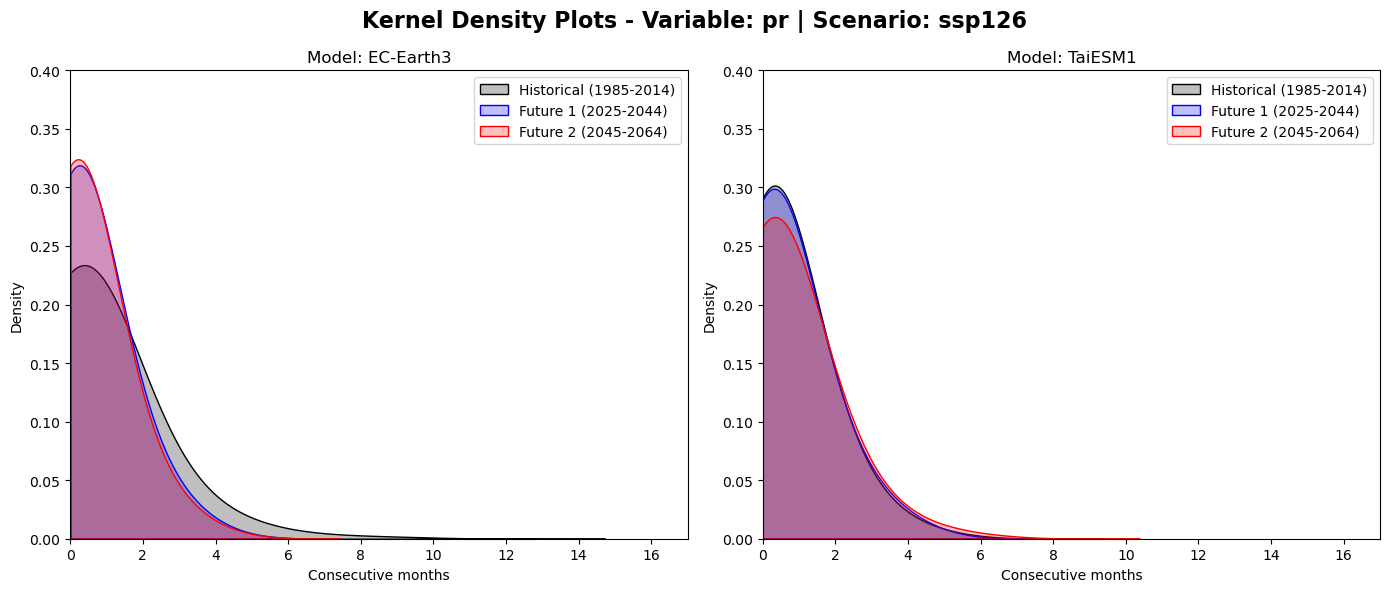

In [58]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp126'

kernel_density_plots(variable=variables, model_names=models, scenarios=scenario)

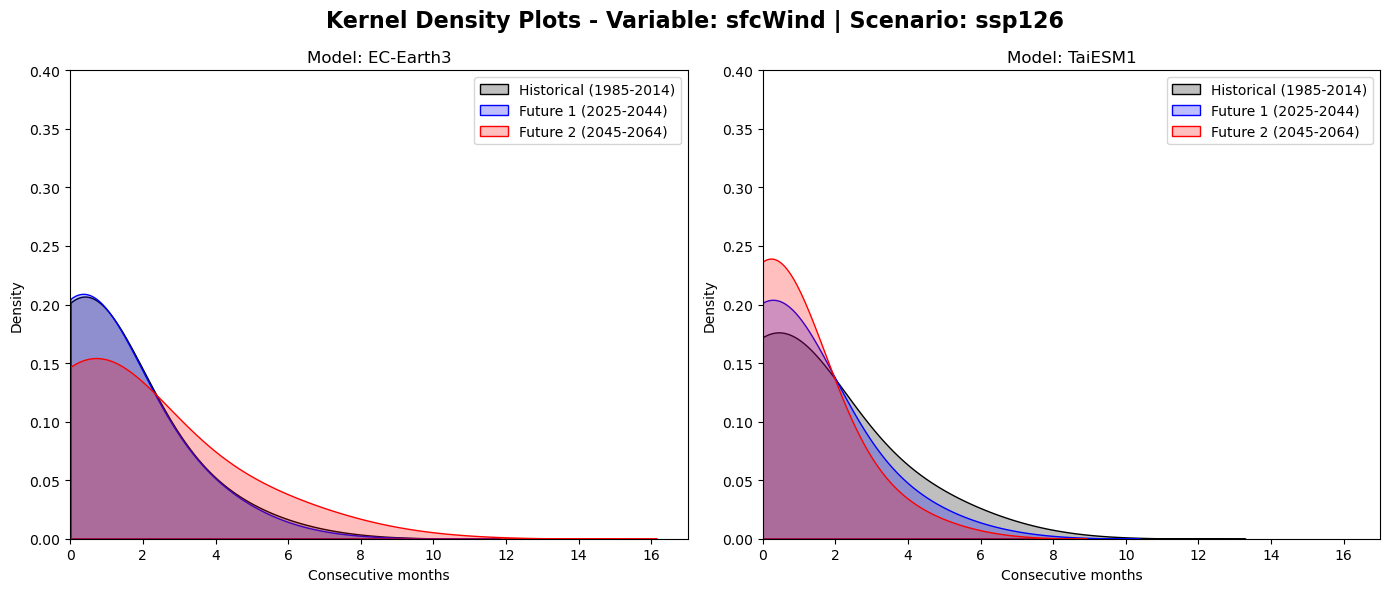

In [59]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp126'

kernel_density_plots(variable=variables, model_names=models, scenarios=scenario)

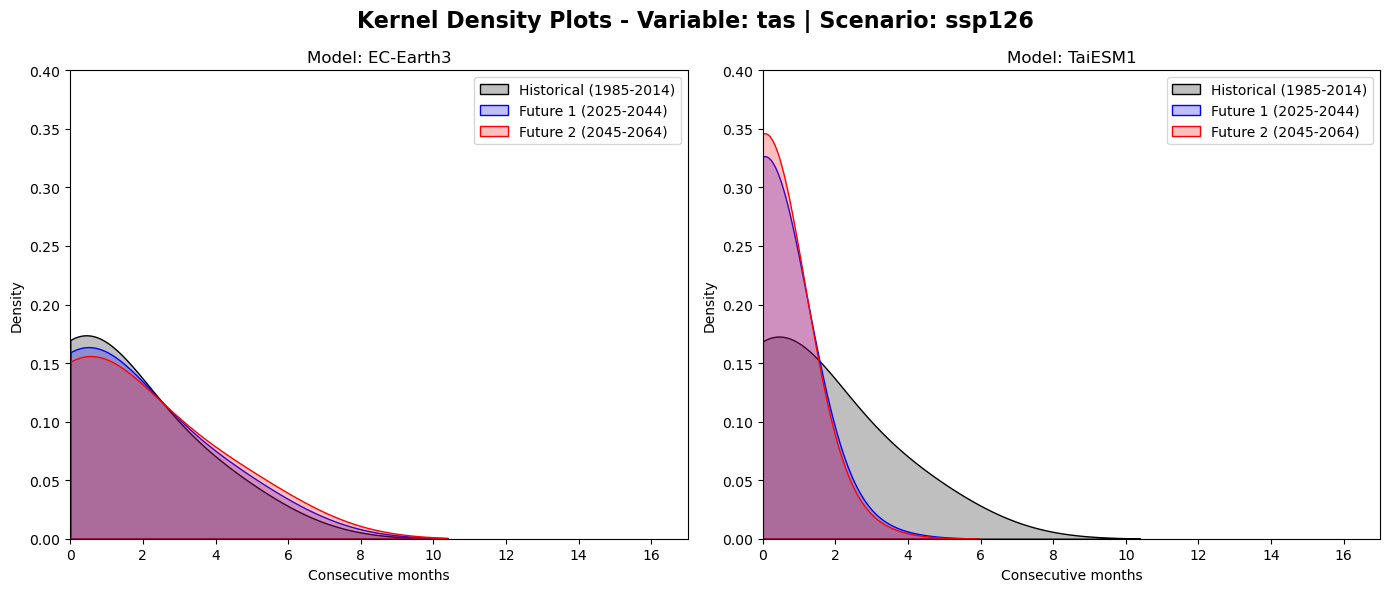

In [60]:
models =['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp126'

kernel_density_plots(variable=variables, model_names=models, scenarios=scenario)

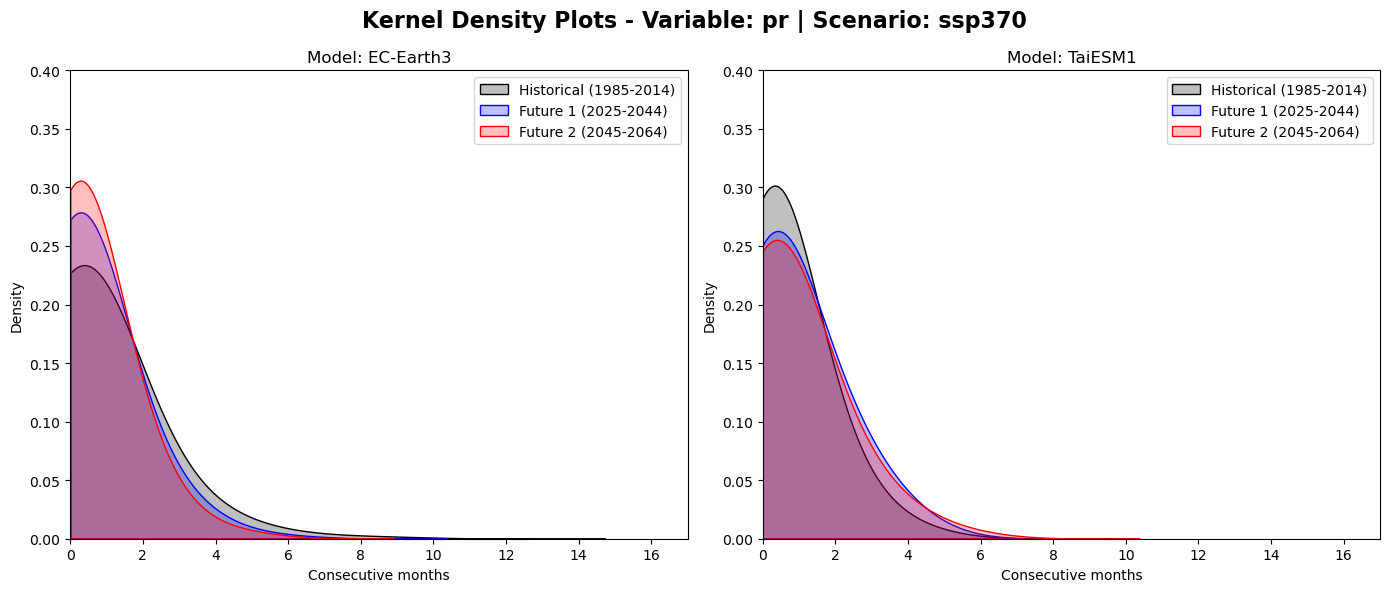

In [61]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp370'

kernel_density_plots(variable=variables, model_names=models, scenarios=scenario)

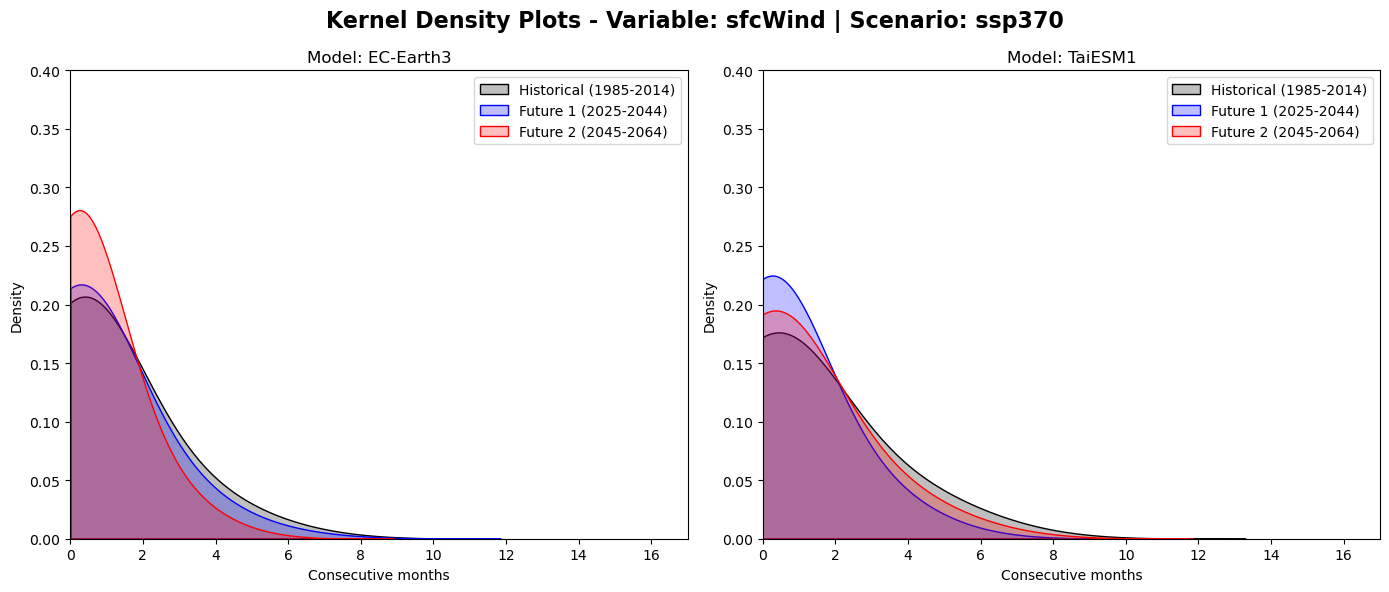

In [62]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp370'

kernel_density_plots(variable=variables, model_names=models, scenarios=scenario)

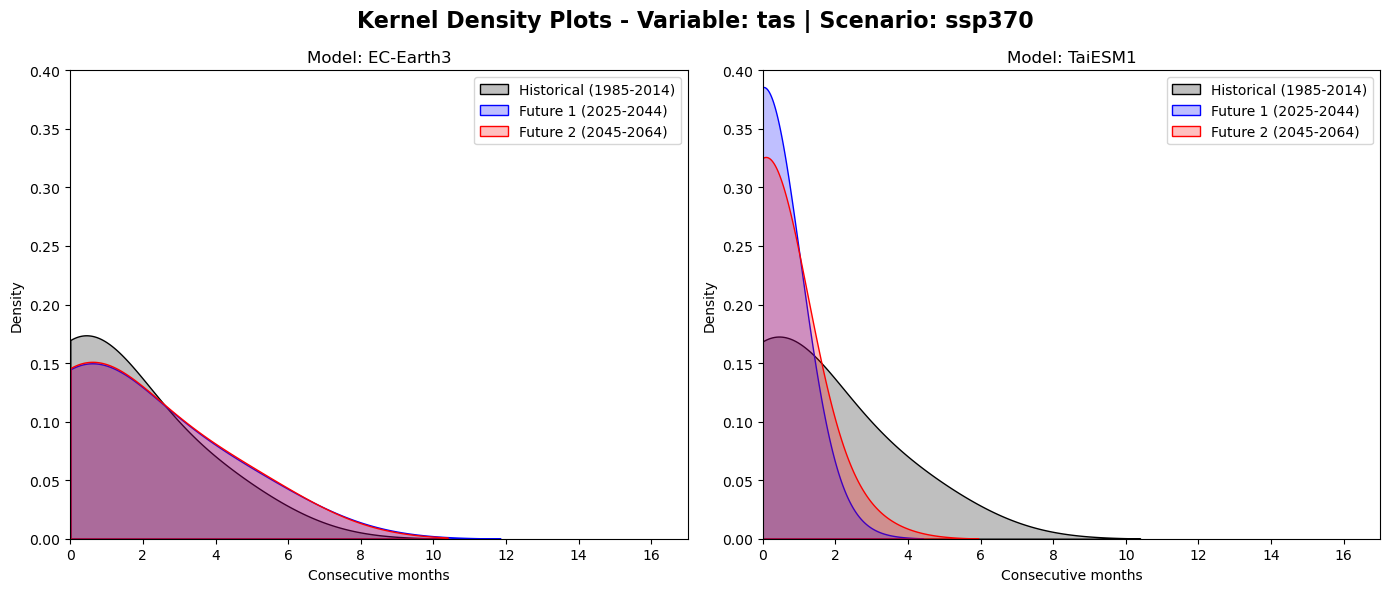

In [63]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp370'

kernel_density_plots(variable=variables, model_names=models, scenarios=scenario)

**COLORMAPS**

I developed colormaps to visualize the alternancy when categories are above or below the limit. Specifically, for 'pr' and 'sfcWind', drought conditions are identified when the category is ≤ 2, while for 'tas', extreme heat conditions are flagged when the category is ≥ 4. These conditions are highlighted in red to make them easily distinguishable.

**classification_dic dictionary:** A nested dictionary was created to store classification data for different climate variables (precipitation, wind speed, and temperature) across multiple climate models, scenarios, and time periods. Each model (e.g., 'EC-Earth3', 'TaiESM1') includes historical and future scenarios (ssp126, ssp370), with entries for each variable ('pr', 'sfcWind', 'tas') containing lists of classified values. This structure allows for the organization and classification of data for each variable by model and scenario.

In [35]:
classification_dic = {
    'EC-Earth3': {
        'historical': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp126': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp370': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        }
    },
    'TaiESM1': {
        'historical': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp126': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        },
        'ssp370': {
            'pr': [],
            'sfcWind': [],
            'tas': []
        }
    }
}

The following steps were followed to fill the classification_dic dictionary:

1. For each climate model ('EC-Earth3' and 'TaiESM1'), variable ('pr', 'sfcWind', 'tas'), and scenario ('historical', 'ssp126', 'ssp370'), I retrieved monthly mean data using the means_dataframe function.

2. For the historical scenario, I classified the climate data based on the historical data using the classification function. The resulting classified data was stored in the classification_dic dictionary for each model, scenario, and variable.

3. For future scenarios ('ssp126' and 'ssp370'), I divided the time periods into two sub-periods: future_1 (2025-2044) and future_2 (2045-2064). I classified the data for each sub-period using the same classification function and stored the results in the classification_dic.

In [36]:
folder='filtered_data'
models = ['EC-Earth3','TaiESM1']
variables=['pr','sfcWind','tas']
scenarios=['historical','ssp126','ssp370']

for model in models:
    for variable in variables:
        historical_means = means_dataframe(folder, variable=variable, model_name=model, scenario='historical')
        
        for scenario in scenarios:
            means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
            
            if scenario != 'historical':
                future_1=means.loc['2025-01':'2044-12']
                future_2=means.loc['2045-01':'2064-12']
                
                classified_1=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_1) #toma means mensuales y clasifica
                classified_2=classification(variable=variable,historical_dataframe=historical_means,dataframe=future_2)

                #FUTURE 1
                classification_dic[model][scenario][variable].append(classified_1[f'{variable}_cat'])  

                #FUTURE 2
                classification_dic[model][scenario][variable].append(classified_2[f'{variable}_cat'])  
            else:
                #Historical case
                means=means_dataframe(folder,variable=variable, model_name=model, scenario=scenario) 
                classified=classification(variable=variable,historical_dataframe=historical_means,dataframe=means) #toma means mensuales y clasifica
            
                classification_dic[model][scenario][variable].append(classified[f'{variable}_cat'])  

In [37]:
# classified=classification_dic['EC-Earth3']['ssp126']['pr']
# classified[1]

In [38]:
# plt.subplots(figsize=(30,3))
# plt.plot(range(1,241),classified[1],marker='o')
# plt.axhline(y=2, color='red', linestyle='--', linewidth=2)
# plt.xlim(0,240)

In [39]:
# df = pd.DataFrame(classified[1])
# df

In [40]:
# change_points = (df['pr_cat'] <= 2).astype(int).diff().ne(0)

# # Plotting
# plt.figure(figsize=(12, 6))

# # Draw horizontal segments with alternating colors
# start_idx = 0
# for idx in np.where(change_points)[0]:
#     color = 'red' if df['pr_cat'].iloc[start_idx] <= 2 else 'blue'
#     plt.hlines(1, df.index[start_idx], df.index[idx], colors=color, linewidth=3)
#     start_idx = idx

# # Add the final segment
# color = 'red' if df['pr_cat'].iloc[start_idx] <= 2 else 'blue'
# plt.hlines(1, df.index[start_idx], df.index[-1], colors=color, linewidth=3)

# plt.title('On-Off Horizontal Line')
# plt.xlabel('Year-Month')
# plt.yticks([])  # Remove y-axis ticks for clarity
# plt.show()

In [41]:
# # Create a colormap array (1 for red, 0 for blue)
# colormap_values = np.where(df <= 2, 1, 0).reshape(1, -1)

# # Plotting
# plt.figure(figsize=(12, 2))
# plt.imshow(colormap_values, cmap='coolwarm', aspect='auto') #, extent=[0, len(df), 0, 1])

# # X-axis setup (Final Fix)
# # plt.xticks(np.linspace(0, len(df), 10), df.index[::len(df)//10].strftime('%Y-%m'))
# plt.yticks([])  # Hide y-axis labels for a clean look

# plt.title('On-Off Colormap')
# plt.show()

In [42]:
def colormaps(variable=None, model_names=None, scenarios=None):
    """
    Plots scatter plots for different models, scenarios, and time periods using the classification data.
    
    Parameters:
    -----------
    variable : str
        The variable to be visualized in the colormaps (e.g., 'pr', 'sfcWind').
    model_names : list of str
        List of model names to plot the data for.
    scenarios : str
        The scenario for future projections.
    
    This function creates a 2x3 grid of colormap plots for three time periods:
    - Historical (1985-2014)
    - Future 1 (2025-2044)
    - Future 2 (2045-2064)
    Each subplot represents a specific model and time period, with the colormap visualizing 
    classified data based on predefined thresholds.

    Blue: For values <= 2 ('pr','sfcWind') or values < 4 (for 'tas' variable).
    Red: For values > 2 ('pr','sfcWind') or values >= 4 (for 'tas' variable).
    """
    
    # Create a 2x3 grid for the subplots with a specific figure size
    fig, ax = plt.subplots(2, 3, figsize=(18, 4))

    # Time periods for the plot titles and data extraction
    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

    # Loop through each model and each time period to generate the colormap
    for i, model in enumerate(model_names):
        for j, period in enumerate(periods):
            # Select the data based on the period (historical or future)
            if period == 'historical':
                # For historical period, data is accessed directly from the model
                classified_data = classification_dic[model]['historical'][variable]
            elif period == 'future_1':
                # For future period 1, access the data based on the scenario
                classified_data = classification_dic[model][scenarios][variable][0]
            elif period == 'future_2':
                # For future period 2, access the data based on the scenario
                classified_data = classification_dic[model][scenarios][variable][1]

            # Convert the classified data into a DataFrame for easier manipulation
            df = pd.DataFrame(classified_data)

            if variable != 'tas':
                # Create a colormap array (1 for values <= 2, 0 otherwise) for visualization
                colormap_values = np.where(df <= 2, 1, 0).reshape(1, -1)
            else:
                colormap_values = np.where(df >= 4, 1, 0).reshape(1, -1)
            
            ax[i, j].imshow(colormap_values, cmap='coolwarm', aspect='auto')
            ax[i, j].set_title(f'{titles[j]} | Model: {model}')
            ax[i, j].set_yticks([])

    # title for the entire figure
    fig.suptitle(f"Colormaps - Variable: {variable} | Scenario: {scenarios}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

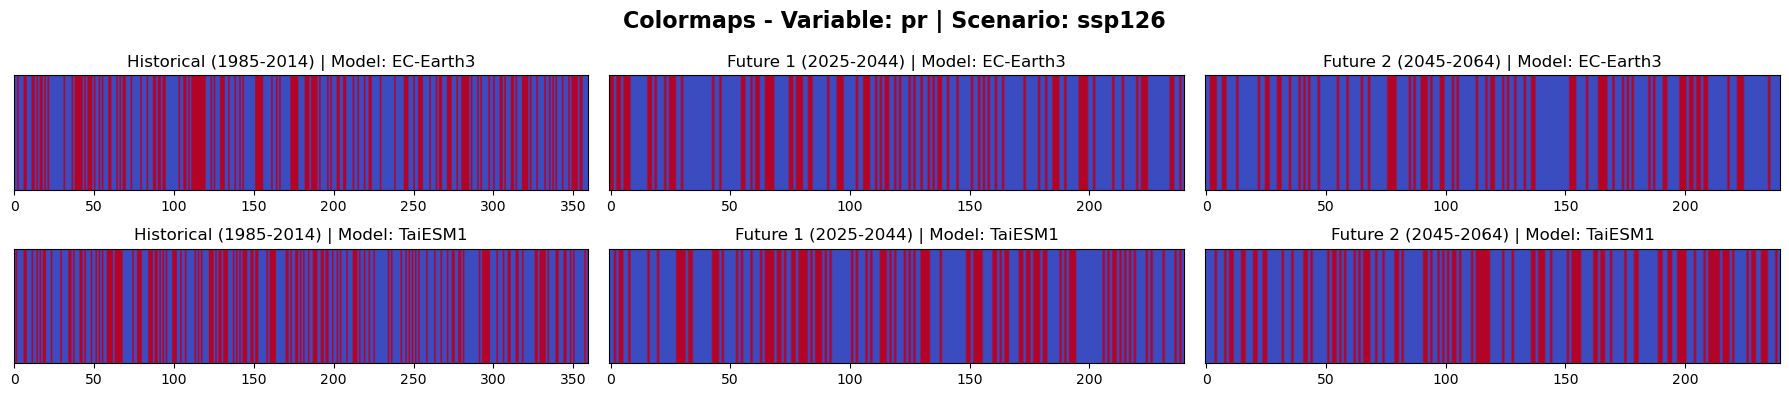

In [43]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp126'

colormaps(variable=variables, model_names=models, scenarios=scenario)

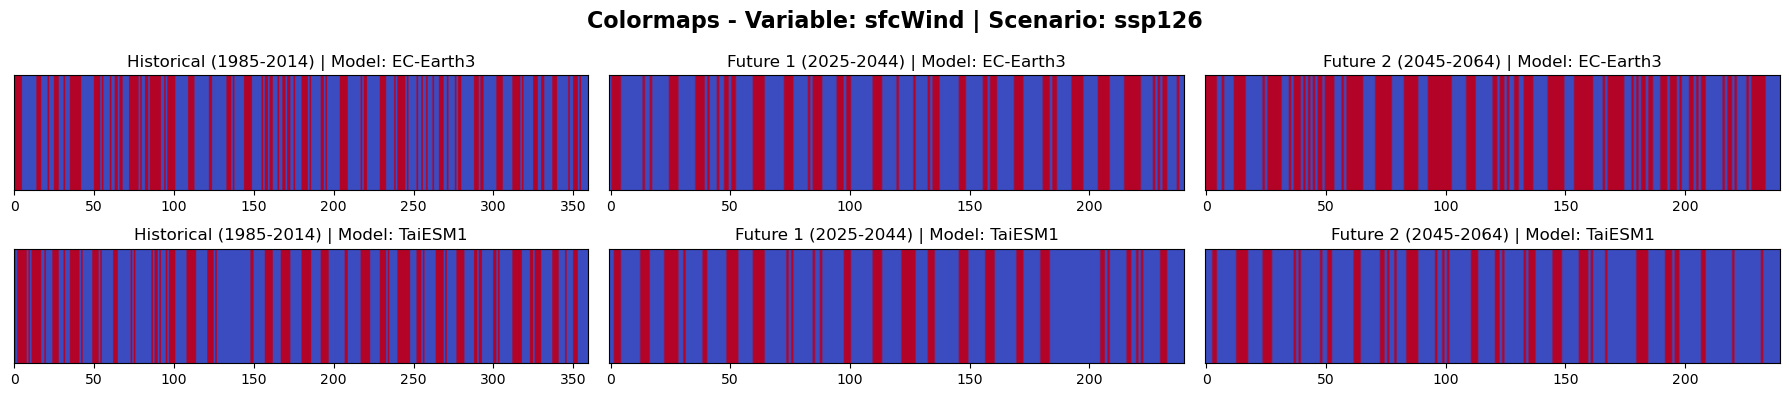

In [44]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp126'

colormaps(variable=variables, model_names=models, scenarios=scenario)

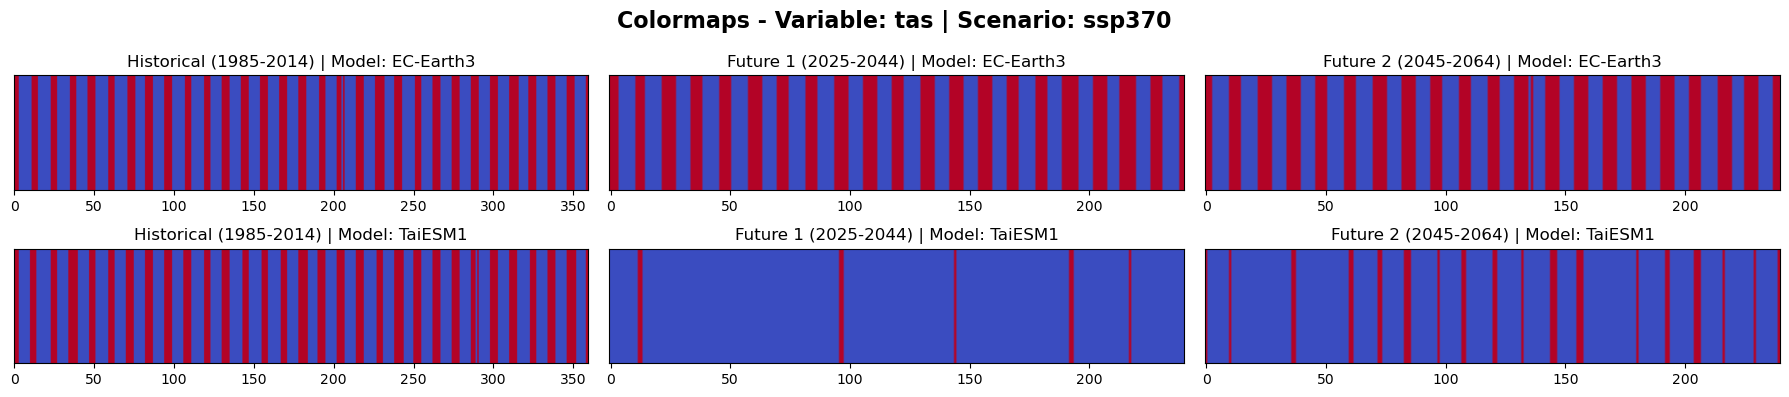

In [45]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp370'

colormaps(variable=variables, model_names=models, scenarios=scenario)

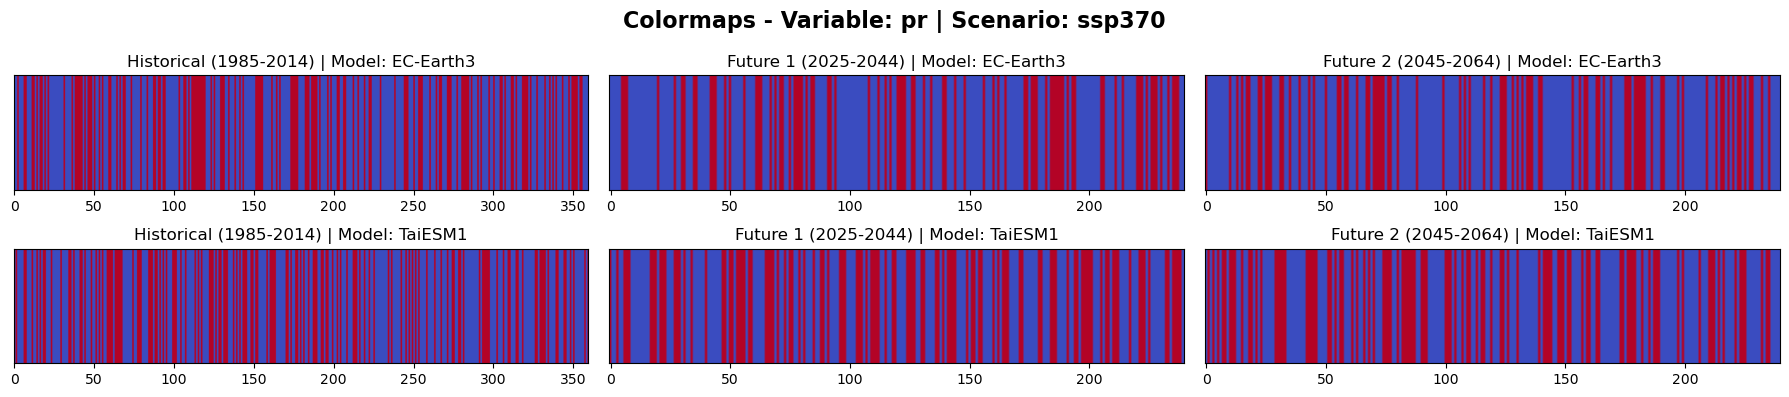

In [46]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp370'

colormaps(variable=variables, model_names=models, scenarios=scenario)

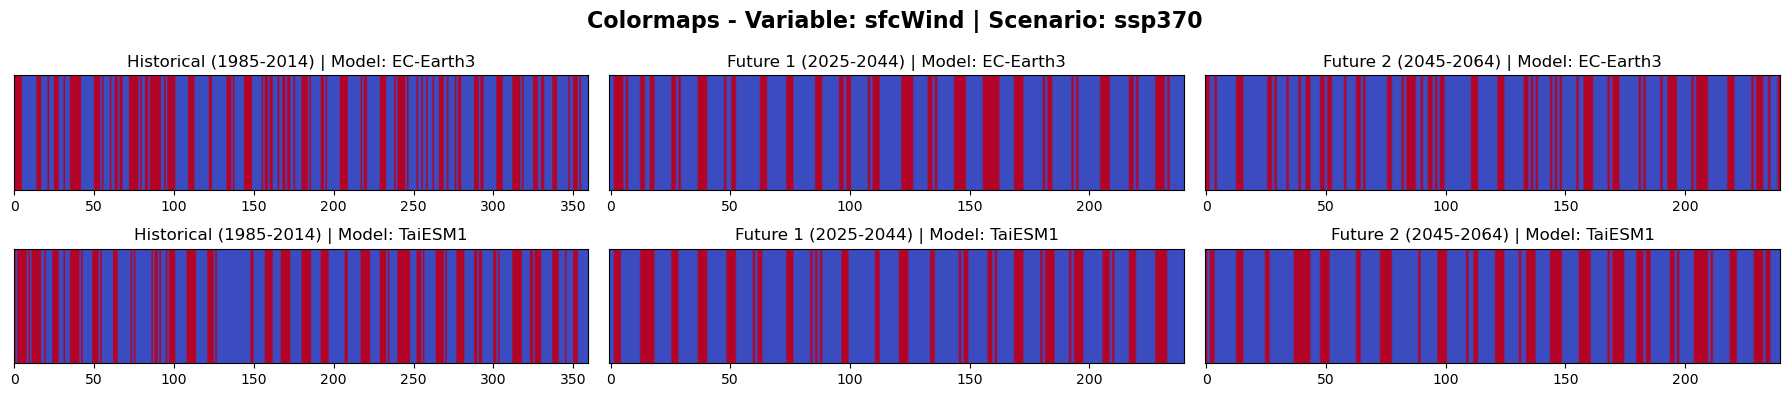

In [47]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp370'

colormaps(variable=variables, model_names=models, scenarios=scenario)

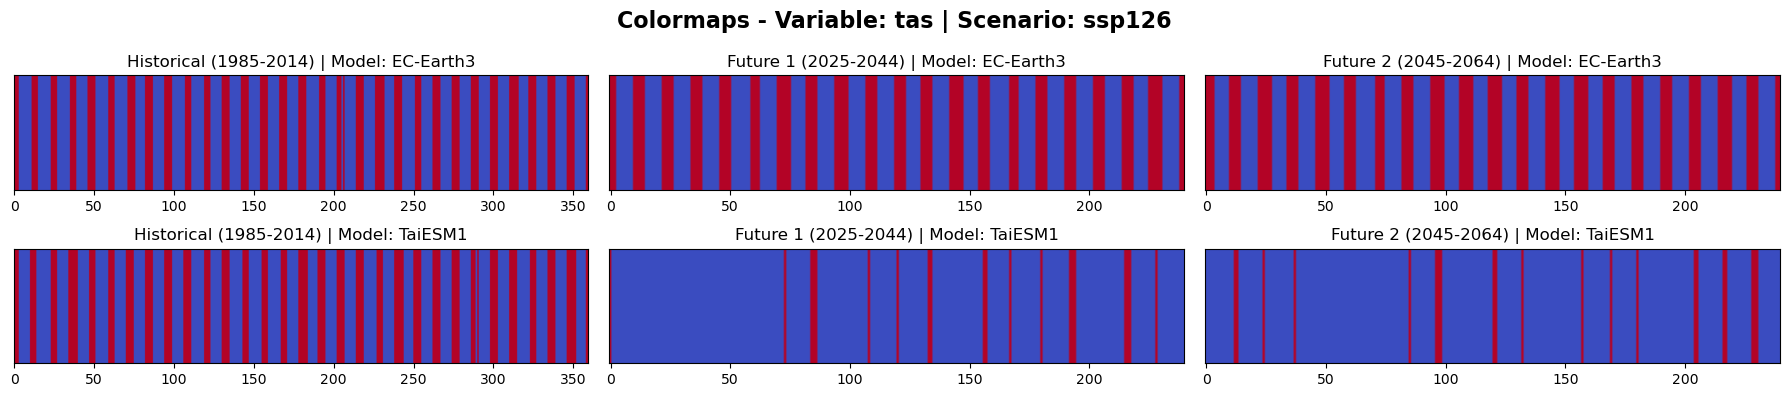

In [48]:
models =['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp126'

colormaps(variable=variables, model_names=models, scenarios=scenario)

**RETURNING PERIOD PLOTS**

In [49]:
# def returning_periods_2(count_sev_dic=count_sev_dic,variable=None, model_names=None, scenarios=None):
#     """
#     Plots the returning periods for different models, scenarios, and time periods.
    
#     Parameters:
#     - count_sev_dic (dict): The dictionary containing the count and severity data for different models and scenarios.
#     - variable (str): The variable to plot (e.g., 'pr', 'sfcWind', 'tas').
#     - model_names (list): List of model names (e.g., ['EC-Earth3', 'TaiESM1']).
#     - scenarios (list): List of scenarios (e.g., ['historical', 'ssp126', 'ssp370']).
    
#     The function generates scatter plots for the returning periods, which represent 
#     the frequency of occurrence of severity episodes for each model, variable, and scenario.
#     The x-axis represents the consecutive months, and the y-axis represents the returning period on a logarithmic scale.
#     """

#     # Define periods and their corresponding titles for the plots
#     periods = ['historical', 'future_1', 'future_2']
#     titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']

#     # Create a figure with subplots for each model
#     fig,ax=plt.subplots(1,2,figsize=(14,6))

#     # Iterate through each model in model_names
#     for i,model in enumerate(model_names):
#         # Iterate through the defined periods and their corresponding titles
#         for period, title in zip(periods, titles):
#             if period == 'historical':
#                 severity_data = count_sev_dic[model][period][variable]['severity']
#             else:
#                 severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]
        
#             # Flatten the severity data list (count_sev_dic has list of lists, so I needed to turn them into a single list)
#             flattened_data = [item for sublist in severity_data for item in sublist]
        
#             # Normalize the severity data to calculate the returning period for each period
#             if period == 'historical': 
#                 # Historical data: period length is 30 years.
#                 normalized_values = [30 / value if value != 0 else 0 for value in flattened_data]
#                 ax[i].scatter(flattened_data, normalized_values, marker='o', label=title)
#             elif period== 'future_1':
#                 # Future 1 data: period length is 20 years.
#                 normalized_values = [20 / value if value != 0 else 0 for value in flattened_data]
#                 ax[i].scatter(flattened_data, normalized_values, marker='s', label=title,s=50)
#             elif period== 'future_2':
#                 # Future 2 data: period length is 20 years.
#                 normalized_values = [20 / value if value != 0 else 0 for value in flattened_data]
#                 ax[i].scatter(flattened_data, normalized_values, marker='D', label=title)
            
#             # Set the x and y labels, and plot title    
#             ax[i].set_xlabel('Consecutive months')
#             ax[i].set_ylabel('Returning period')
#             ax[i].set_title(f'Model: {model}')

#             ax[i].legend()  
#             ax[i].set_yscale('log') 
#             ax[i].grid(True)

#     plt.suptitle(f'Returning period -  Variable: {variable} | Scenario: {scenarios}', fontsize=16, fontweight='bold')
#     plt.show()

In [64]:
def returning_periods(count_sev_dic=count_sev_dic, variable=None, model_names=None, scenarios=None):
    """
    Plots the returning periods for different models, scenarios, and time periods.
    
    Parameters:
    - count_sev_dic (dict): The dictionary containing the count and severity data for different models and scenarios.
    - variable (str): The variable to plot (e.g., 'pr', 'sfcWind', 'tas').
    - model_names (list): List of model names (e.g., ['EC-Earth3', 'TaiESM1']).
    - scenarios (list): List of scenarios (e.g., ['historical', 'ssp126', 'ssp370']).
    
    The function generates scatter plots for the returning periods, which represent 
    the frequency of occurrence of severity episodes for each model, variable, and scenario.
    The x-axis represents the severity, and the y-axis represents the returning period on a logarithmic scale.
    """
    periods = ['historical', 'future_1', 'future_2']
    titles = ['Historical (1985-2014)', 'Future 1 (2025-2044)', 'Future 2 (2045-2064)']
    colors=['black','blue','red']

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    for i, model in enumerate(model_names):
        for j,(period, title) in enumerate(zip(periods, titles)):
            if period == 'historical':
                severity_data = count_sev_dic[model][period][variable]['severity']
                period_length = 30  # Historical period length (30 years)
            else:
                severity_data = count_sev_dic[model][scenarios][variable]['severity'][period]
                period_length = 20  # Future period lengths (20 years)

            flattened_data = [item for sublist in severity_data for item in sublist]
            unique_severity = sorted(set(flattened_data))

            severity_counts = {sev: flattened_data.count(sev) for sev in unique_severity}

            if period == 'historical':
                period_length = 30
            else:
                period_length = 20

            severities = list(severity_counts.keys())  #I used ChatGPT to get help on these lines
            returning_periods = [period_length / severity_counts[sev] for sev in severities if severity_counts[sev] != 0]

            ax[i].plot(severities, returning_periods, color=colors[j], marker='o' if period == 'historical' else ('s' if period == 'future_1' else 'D'), label=title)

            ax[i].set_xlabel('Consecutive months')
            ax[i].set_ylabel('Returning period (years)')
            ax[i].set_title(f'Model: {model}')

            ax[i].set_xlim(0,11)
            ax[i].set_ylim(0,32)
            
            ax[i].legend()
            ax[i].grid(True)

    plt.suptitle(f'Returning period - Variable: {variable} | Scenario: {scenarios}', fontsize=16, fontweight='bold')
    plt.show()

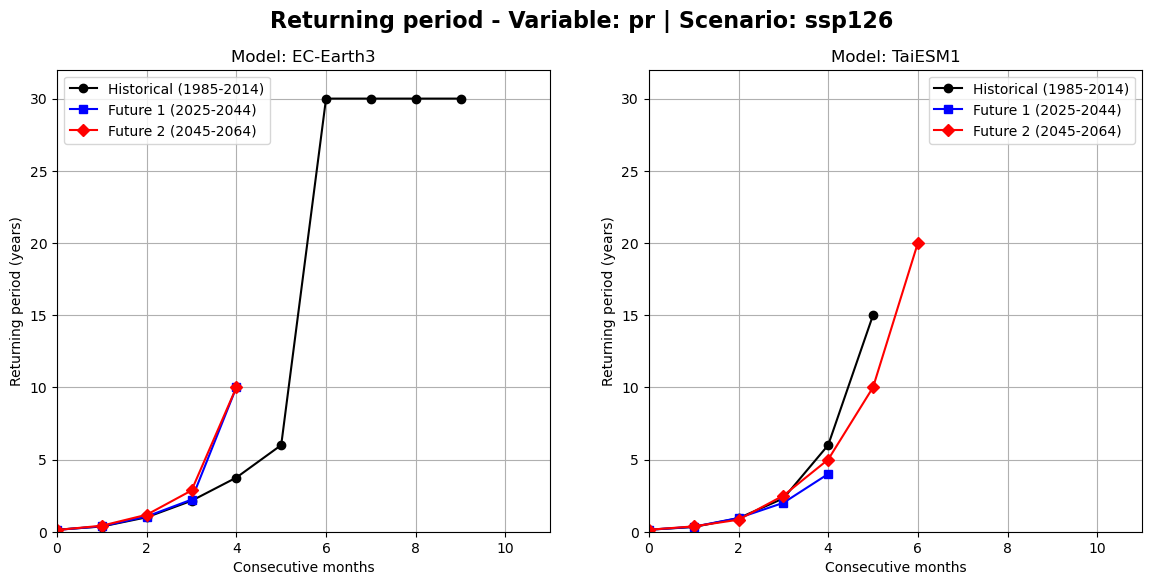

In [65]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp126'

returning_periods(variable=variables, model_names=models, scenarios=scenario)

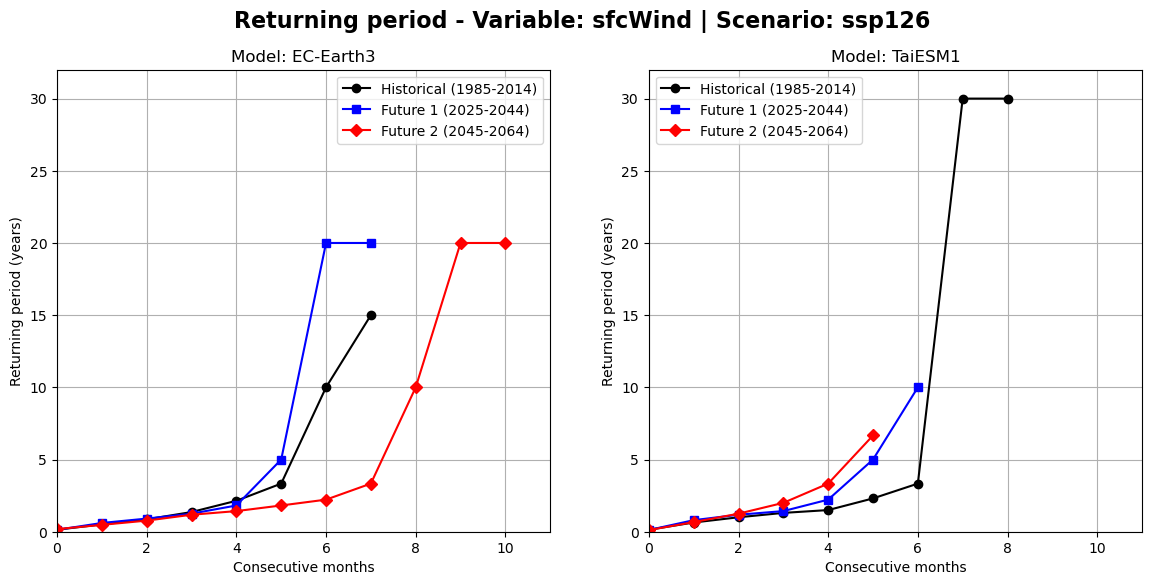

In [66]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp126'

returning_periods(variable=variables, model_names=models, scenarios=scenario)

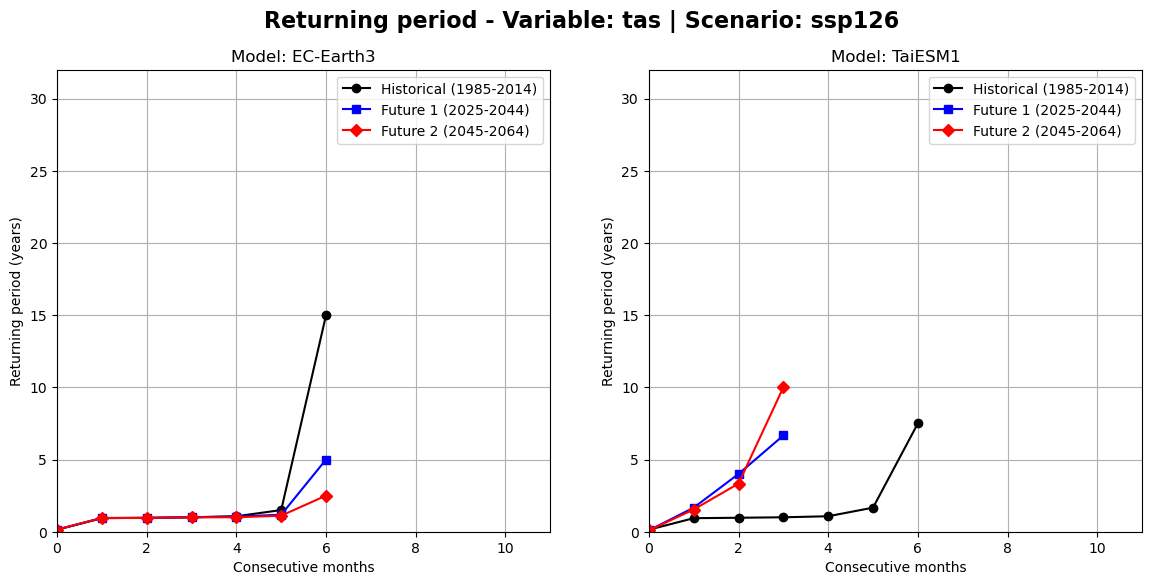

In [67]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp126'

returning_periods(variable=variables, model_names=models, scenarios=scenario)

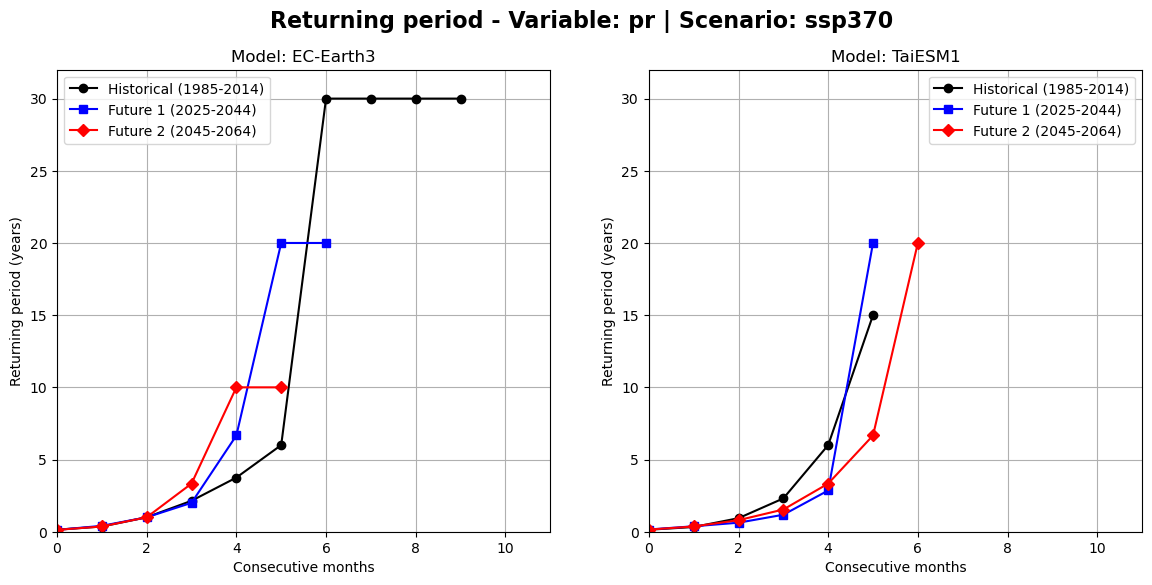

In [68]:
models = ['EC-Earth3','TaiESM1']
variables='pr'
scenario='ssp370'

returning_periods(variable=variables, model_names=models, scenarios=scenario)

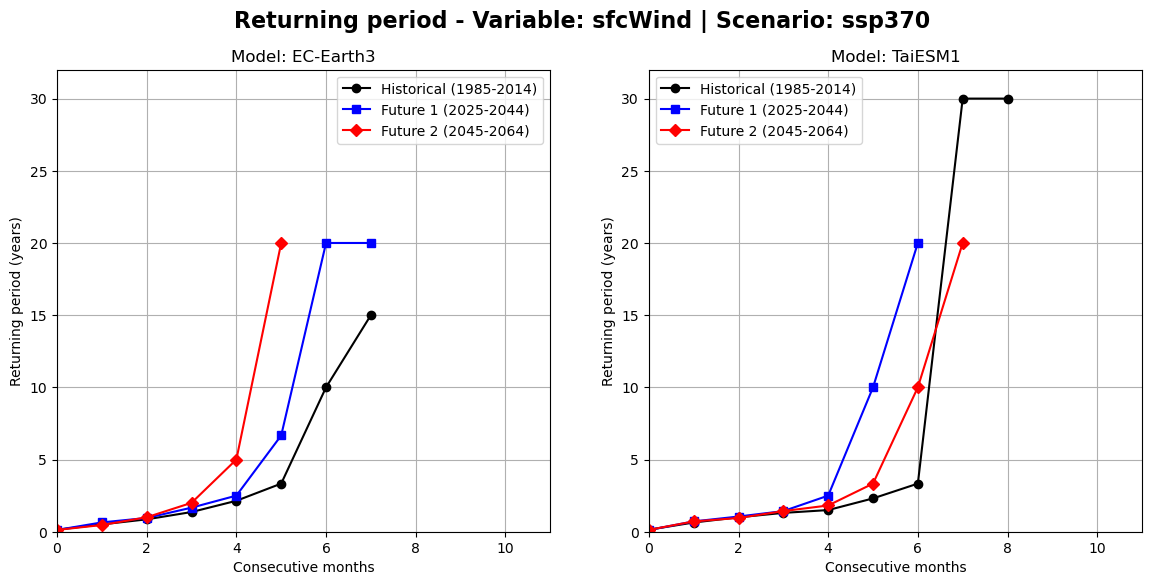

In [69]:
models = ['EC-Earth3','TaiESM1']
variables='sfcWind'
scenario='ssp370'

returning_periods(variable=variables, model_names=models, scenarios=scenario)

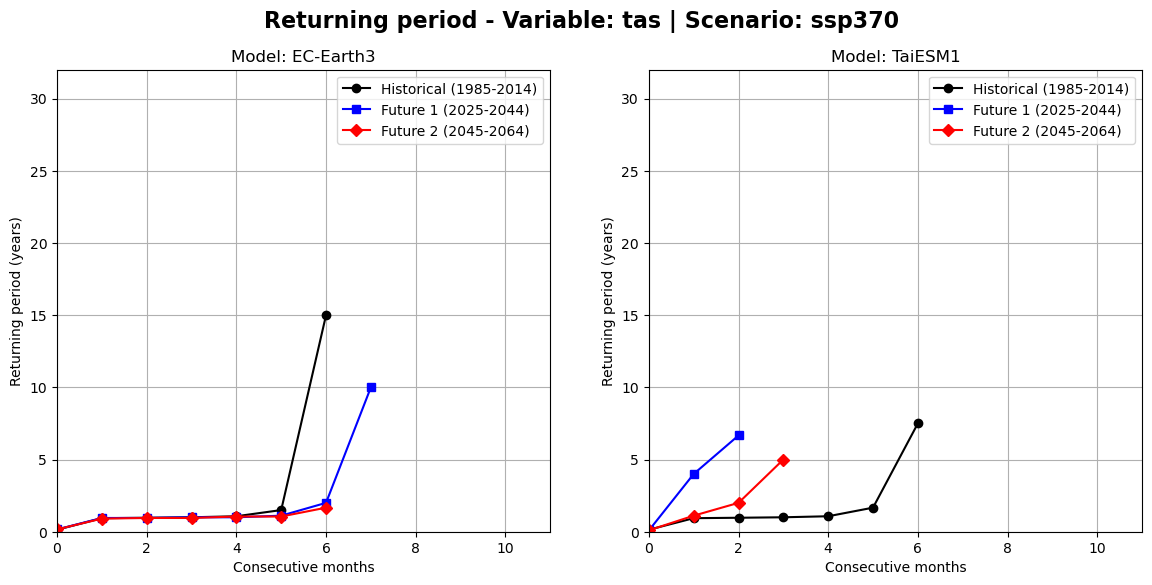

In [70]:
models = ['EC-Earth3','TaiESM1']
variables='tas'
scenario='ssp370'

returning_periods(variable=variables, model_names=models, scenarios=scenario)